In [1]:
from main import *
from file_helpers import *

In [2]:
import sys

import numpy as np
import matplotlib.pyplot as plt

import peak_detection as pdetect
import peak_statistics as pstats
import file_helpers as fh

def process_data(filepath, plot = False):
    """
    ================
    INPUT: string (filepath), boolean
    OUTPUT: several statistics, and a plot if "plot" parameter is True
    ================

    Returns enthalpy about the data, and plots it, the endpoints and the
    line if you want (as well as statistics)

    """

    # clean the data
    data = fh.clean_file(filepath)

    #find the first number in the filename and use as the title
    name_of_preparation = fh.get_file_title(filepath)

    # ensure that the data is formatted correctly, as arrays
    temp, heat_flow = np.array(data.temp), np.array(data.heat_flow)

    # generate statistics
    e, hf, t, sd, (onset_point, end_point) = pstats.get_statistics(temp, heat_flow)

    statistics_text = """=== Preparation {0} ===
    Enthalpy: {1}
    Peak Heat Flow: {2}
    Peak Temperature: {3}
    Heat Flow Standard Devation: {4}
    Onset point: {5}, {6}
    End point: {7}, {8}
    """.format(name_of_preparation,
               round(e, 3),
               round(hf, 3),
               round(t, 2),
               round(sd, 4),
               round(onset_point[0], 2),
               round(onset_point[1], 3),
               round(end_point[0], 2),
               round(end_point[1], 3)
               )

    if plot:
        # get line for plotting
        line_X, line_y = pstats.fit_line(temp, heat_flow)

        # get onset and end points
        (x0, y0), (x1, y1) = pdetect.get_points_coordinates(temp, heat_flow)

        # set up plot
        fig, ax = plt.subplots(1)
        ax.set_title("Preparation {}".format(name_of_preparation))
        ax.set_xlabel("Temperature")
        ax.set_ylabel("Heat Flow")
        ax.annotate(statistics_text,
                    xy=(0.5, 0.4),
                    xycoords='axes fraction'
                    )

        # plot original data
        plt.plot(temp,
               heat_flow,
               color = 'black',
               label = "Original data"
              )

        # plot best fit line
        plt.plot(line_X,
               line_y,
               color = 'red',
               label = "Best fit line"
              )

        # plot onset point
        plt.scatter(x0,
                  y0,
                  color = 'green',
                  label = 'Onset: {}, {}'.format(round(x0,2), round(y0, 2))
                 )

        # plot end point
        plt.scatter(x1,
                  y1,
                  color = 'purple',
                  label = 'End: {}, {}'.format(round(x1, 2), round(y1, 2))
                 )
        plt.legend()
        plt.show()

    return e # this is short for enthalpy, as defined above

In [3]:
fnames = get_files()

In [4]:
process_data(fnames[8], plot = True)

4.210972201515923

In [7]:
X, y = clean_file(fnames[8]).temp, clean_file(fnames[0]).heat_flow

In [18]:
import numpy as np

from scipy.interpolate import UnivariateSpline
from scipy.signal import argrelextrema


def find_onset_point(X, y):
    """
    ================
    INPUT: array of X data (temperature), array of Y data (heat flow)
    OUTPUT: int
    ================

    In order, this function:

    1. Smooths the data and approximates it with a spline.

    2. Finds the second derivative.

    3. Finds where the second derivative of the approximation is minimized,
    which in this data coincides with just before the reaction begins.
    That point is the starting point for the reaction.

    """
    second_derivative = UnivariateSpline(X, y, k = 5).derivative(2)(X)

    local_minima = argrelextrema(second_derivative, np.less)[0]
    relevant_minima_points = local_minima[local_minima > 100] # crop off the first tail

    start_point_id = relevant_minima_points[0] # take the first relevant point

    return start_point_id

def find_ending_point(X, y, start_point):
    """
    ================
    INPUT: array of X data (temperature), array of Y data (heat flow), int
    OUTPUT: int
    ================

    Use this once you find the starting point.

    In order, this function:

    1. Isolates data after the reaction has started, which is more or less
    a fat-tailed normal distribution

    2. Approximates the data with a spline.

    3. Finds the point where the first derivative is closest to zero and nearest
    to the end of the reaction. This is the end point.
        ## note, you could also set the end point to be when the function has returned closest
        ## to the gradient at the start_point

    4. If this point is < post-peak max point, choose the maximum point.

    """
    reaction_x = X[start_point:] # x's after the start_point
    reaction_y = y[start_point:] # y's after the start_point
    index_of_peak = reaction_y.argmin()

    spline = UnivariateSpline(reaction_x, reaction_y, k = 5)
    second_derivative = spline.derivative(2)(reaction_x)

    relevant_end_points = np.abs(second_derivative)
    end_point = np.max(relevant_end_points.argsort()[:50])# get the largest of all the zero points
    end_point_id = start_point + end_point #end point is measured as points from end of experiment

    # if there's a greater point between peak and end point, choose  it
    if np.max(y[index_of_peak : end_point_id]) > y[end_point_id]:
        index = y[index_of_peak : end_point_id].argmax()
        end_point_id = index_of_peak + index

    return end_point_id

In [19]:
start_point = 1400

In [20]:
reaction_x = X[start_point:] # x's after the start_point
reaction_y = y[start_point:] # y's after the start_point
index_of_peak = reaction_y.argmin()

spline = UnivariateSpline(reaction_x, reaction_y, k = 5)
second_derivative = spline.derivative(2)(reaction_x)

relevant_end_points = np.abs(second_derivative)
end_point = np.max(relevant_end_points.argsort()[:50])# get the largest of all the zero points
end_point_id = start_point + end_point #end point is measured as points from end of experiment

# if there's a greater point between peak and end point, choose  it
if np.max(y[index_of_peak : end_point_id]) > y[end_point_id]:
    index = y[index_of_peak : end_point_id].argmax()
    end_point_id = index_of_peak + index

In [22]:
%matplotlib inline

<function matplotlib.pyplot.scatter>

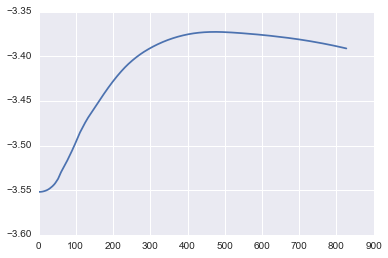

In [31]:
plt.plot(y[index_of_peak:])
plt.scatter